https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid/data

In [32]:
import math
import itertools
import os
import pandas as pd
import numpy as np
import operator
from collections import defaultdict
from scipy.stats import boxcox, shapiro, probplot, jarque_bera
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
%matplotlib inline

In [21]:
path = 'C:/Users/Admin/Documents/NCKH/Scientific_Research/Task 3_07032025/csvs_per_year'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in files), sort=False)
df = df.groupby(['date']).agg('mean')
df.index = pd.DatetimeIndex(data= df.index)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151896 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BEN      151867 non-null  float64
 1   CO       151868 non-null  float64
 2   EBE      151867 non-null  float64
 3   MXY      82190 non-null   float64
 4   NMHC     151868 non-null  float64
 5   NO_2     151868 non-null  float64
 6   NOx      92716 non-null   float64
 7   OXY      82190 non-null   float64
 8   O_3      151868 non-null  float64
 9   PM10     151837 non-null  float64
 10  PXY      82185 non-null   float64
 11  SO_2     151868 non-null  float64
 12  TCH      151869 non-null  float64
 13  TOL      151867 non-null  float64
 14  station  151896 non-null  float64
 15  PM25     124629 non-null  float64
 16  NO       64241 non-null   float64
 17  CH4      5087 non-null    float64
dtypes: float64(18)
memory usage: 22.0 MB


C:\Users\Admin\AppData\Local\Temp\ipykernel_12256\4186898441.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm10_df = pd.DataFrame(df['PM10'].resample('M').mean())


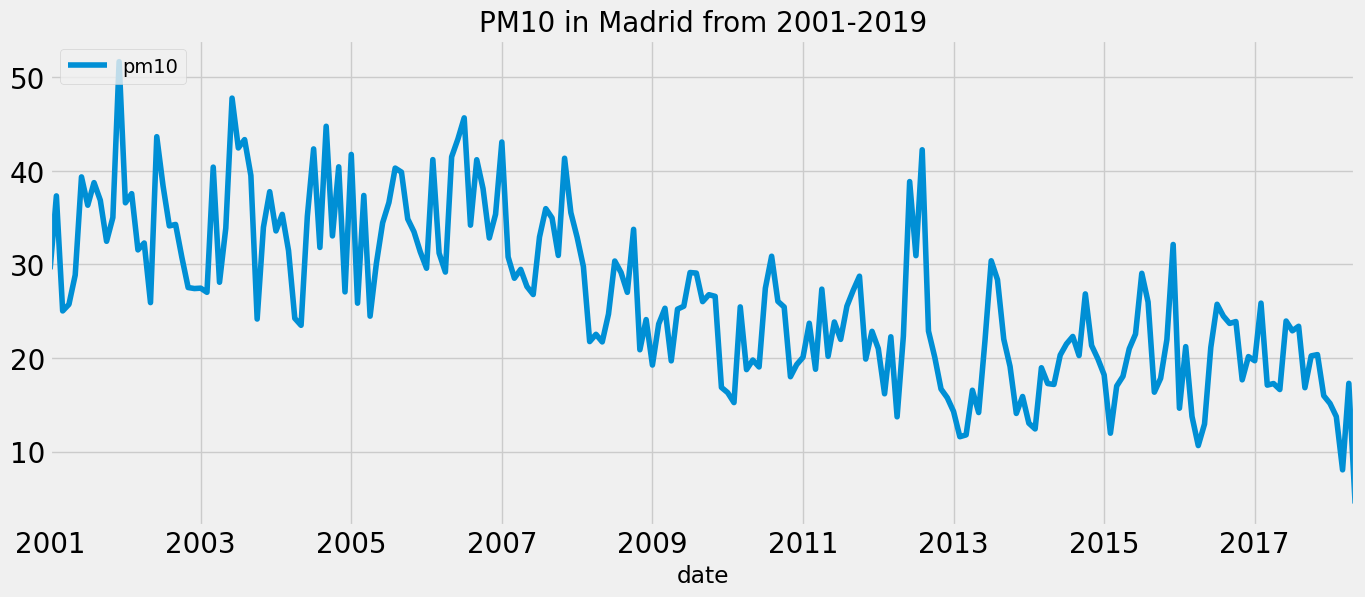

In [27]:
col_list = ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'O_3', 'PM10', 'SO_2', 'TCH', 'TOL']
pm10_df = pd.DataFrame(df['PM10'].resample('M').mean())
pm10_df.rename(columns= {'PM10':'pm10'}, inplace=True)
pm10_df.plot(figsize=(15, 6))
plt.title('PM10 in Madrid from 2001-2019', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 1A: Stationarize Data
### Biến đổi Box Cox
Biến đổi Box Cox làm cho dữ liệu không chuẩn phân phối chuẩn. Chúng ta có thể truyền cho nó một đối số để lambda tự động thực hiện phép biến đổi logarit, phép biến đổi căn bậc hai hoặc phép biến đổi nghịch đảo. Nếu chúng ta không truyền đối số nào cho lambda, nó sẽ tự động điều chỉnh và trả về giá trị lambda.

### Tham số d
Tính chênh lệch dữ liệu của mình lên chênh lệch bậc ba và vẽ biểu đồ để chúng ta có thể thấy chuỗi thời gian thay đổi như thế nào.
Sau chênh lệch lần hai, thì cả KPSS và ADF đều trả về trạng thái tĩnh nên chúng ta không chạy bất kỳ thử nghiệm nào nữa và ta sẽ sử dụng chênh lệch thứ hai cho giá trị d của mình.

In [23]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('Null Hypothesis: Unit Root Present')
    print('Test Statistic < Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print (dfoutput, '\n')

def kpss_test(timeseries, regression='c'):   #constant or constant và trend (ct)
    print ('Results of KPSS Test:')
    print('Null Hypothesis: Data is Stationary/Trend Stationary')
    print('Test Statistic > Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    kpsstest = kpss(timeseries, regression=regression)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}'] = value
    print (kpss_output, '\n')


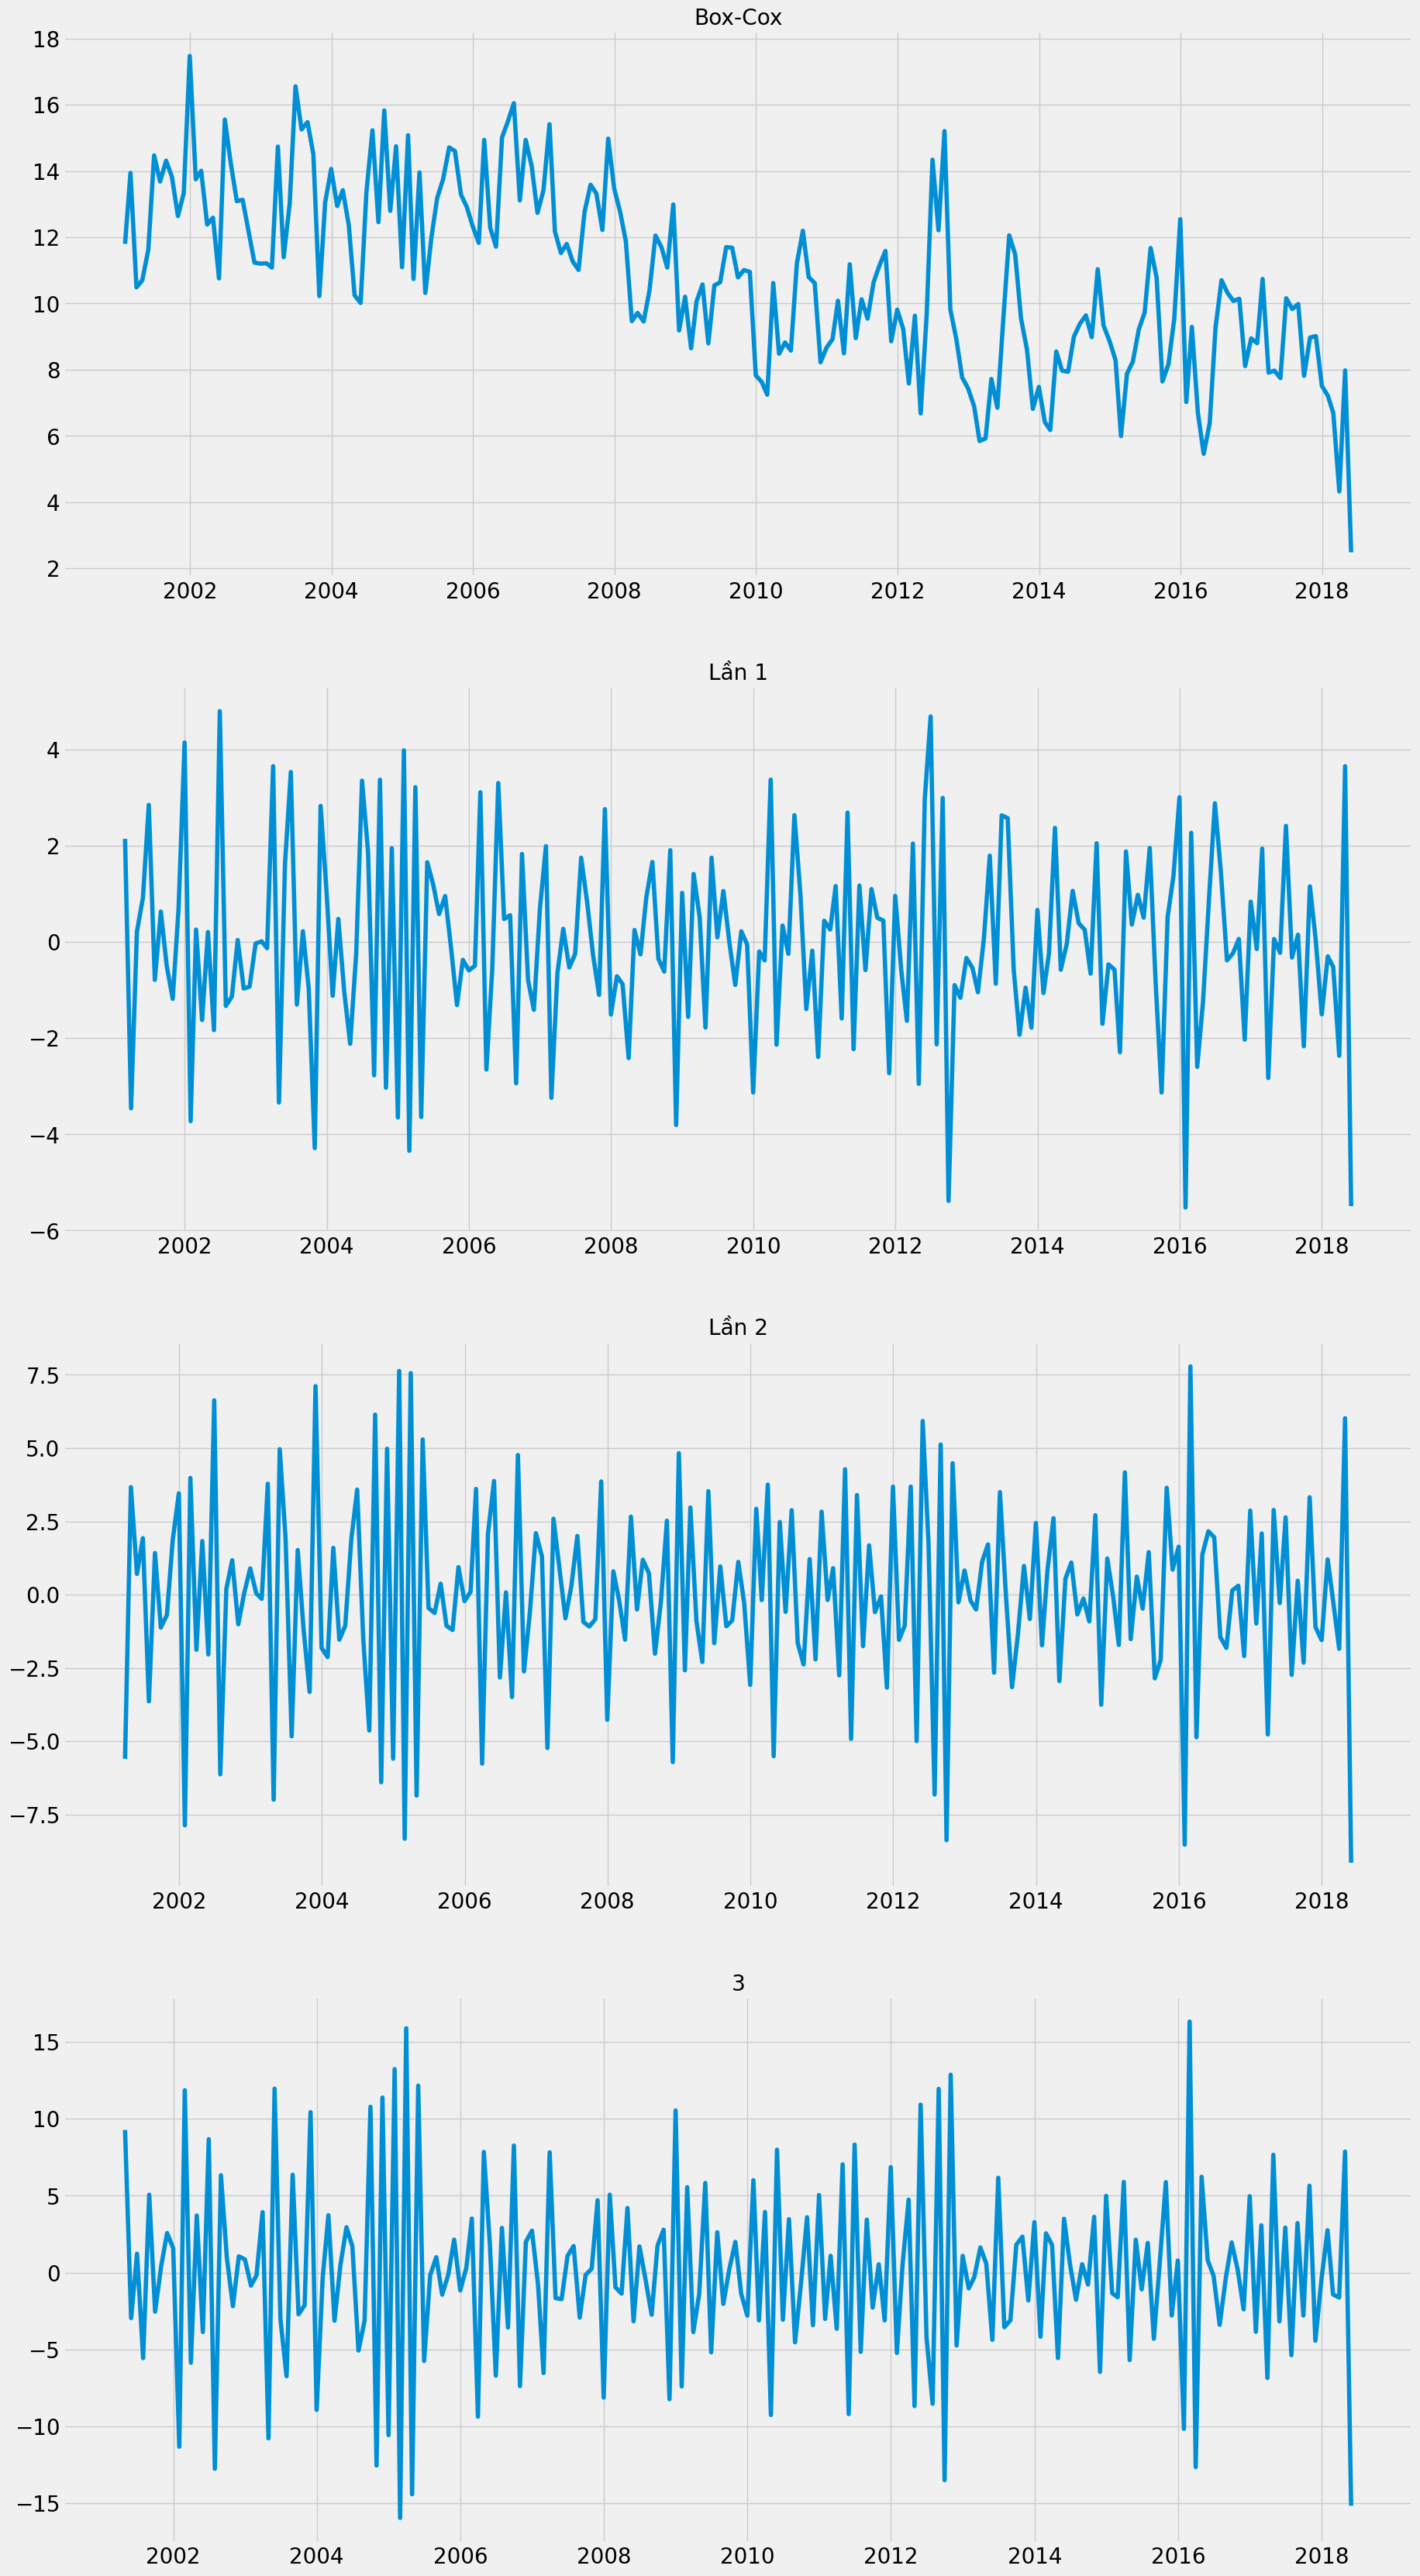

Unit Root Tests:
BoxCox-No Difference
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                  -0.474215
p-value                          0.896951
#Lags Used                      11.000000
Number of Observations Used    194.000000
Critical Value 1%               -3.464515
Critical Value 5%               -2.876556
Critical Value 10%              -2.574775
dtype: float64 

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic         2.082596
p-value                0.010000
Lags Used              8.000000
Critical Value 10%     0.347000
Critical Value 5%      0.463000
Critical Value 2.5%    0.574000
Critical Value 1%      0.739000
dtype: float64 


First Difference:
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic

C:\Users\Admin\AppData\Local\Temp\ipykernel_12256\2337973514.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12256\2337973514.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression)


In [26]:
pm10_df['bc_pm10'], lamb = boxcox(pm10_df.pm10)
pm10_df['d1_pm10'] = pm10_df['bc_pm10'].diff()
pm10_df['d2_pm10'] = pm10_df['d1_pm10'].diff()
pm10_df['d3_pm10'] = pm10_df['d2_pm10'].diff()
fig = plt.figure(figsize=(20,40))

plt_bc = plt.subplot(411)
plt_bc.plot(pm10_df.bc_pm10)
plt_bc.title.set_text('Box-Cox')
plt_d1 = plt.subplot(412)
plt_d1.plot(pm10_df.d1_pm10)
plt_d1.title.set_text('Lần 1')
plt_d2 = plt.subplot(413)
plt_d2.plot(pm10_df.d2_pm10)
plt_d2.title.set_text('Lần 2')
plt_d3 = plt.subplot(414)
plt_d3.plot(pm10_df.d3_pm10)
plt_d3.title.set_text('3')
plt.show()

pm10_df.dropna(inplace=True)

print('Unit Root Tests:')
print('BoxCox-No Difference')
adf_test(pm10_df.bc_pm10)
kpss_test(pm10_df.bc_pm10)
print('\nFirst Difference:')
adf_test(pm10_df.d1_pm10)
kpss_test(pm10_df.d1_pm10)


# 2: Ước tính tham số Parameter Estimation
Để tìm ước tính tốt nhất cho mô hình ARIMA của chúng ta, chúng ta sẽ thử các tham số mà chúng ta tự tìm kiếm cũng như sử dụng một lưới tìm kiếm sẽ tìm kiếm kỹ lưỡng các tham số mô hình tốt nhất.
## Đo lường mô hình Measuring Moels
#### Lỗi phụ thuộc vào thang đo Scale dêpendent Errors
Lỗi phụ thuộc vào thang đo là lỗi trên cùng thang đo với dữ liệu. 
- Lỗi trung bình bình phương (MAE)
- Lỗi trung bình bình phương căn bậc hai (RMSE)

#### Lỗi phần trăm Percentage Errors
Lỗi phần trăm không có đơn vị và thường được sử dụng để so sánh hiệu suất dự báo giữa các tập dữ liệu. Lỗi phần trăm thường là một dạng của estimate_value/true_value. Nhược điểm của lỗi phần trăm là chúng có thể dẫn đến các giá trị vô hạn hoặc không xác định khi giá trị thực bằng không. Ngoài ra, khi dữ liệu không có số không có nghĩa, như nhiệt độ, sự kết hợp của phép chia và sau đó là giá trị tuyệt đối, như trong MAPE, có thể dẫn đến các lỗi không nắm bắt được sự khác biệt thực sự. 
- Lỗi phần trăm tuyệt đối trung bình (MAPE)
- MAPE đối xứng: Xử lý xu hướng của MAPE là áp dụng hình phạt nặng hơn đối với các lỗi tiêu cực

#### Lỗi được chia tỷ lệ Scaled Errors
Lỗi được chia tỷ lệ là một nỗ lực để giải quyết một số vấn đề với lỗi phần trăm. - Lỗi được chia tỷ lệ tuyệt đối trung bình (MASE)

#### Tiêu chuẩn thông tin Akaike (AIC) Akaine Information Criterion
AIC cung cấp cho chúng ta ước tính về chất lượng mô hình bằng cách cố gắng cân bằng độ phức tạp của mô hình với mức độ phù hợp của mô hình với dữ liệu. AIC sử dụng kết hợp giữa khả năng xảy ra logarit và hình phạt đối với các mô hình có nhiều tham số để tìm ra mô hình không quá phù hợp cũng không thiên vị. AIC được sử dụng làm thước đo để so sánh một tập hợp các mô hình vì nó không cung cấp cho chúng ta điểm tuyệt đối mà là điểm tương đối, điểm AIC thấp hơn báo hiệu một mô hình tốt hơn.

## Gridsearch
Gridsearch là một cuộc đi bộ có thứ tự trên không gian tham số của chúng ta, nơi chúng ta có thể sử dụng sức mạnh tính toán để bù đắp cho kinh nghiệm. Chúng ta sẽ sử dụng gridsearch, nơi phù hợp với mô hình của chúng ta với mọi kết hợp tham số và đánh giá các mô hình của chúng ta để xem tập hợp tham số nào tạo ra sự phù hợp tốt nhất. Chúng tôi sẽ sử dụng AIC và RMSE để đánh giá.

In [7]:
def evaluate_model(data, pdq):
    split_date = '2012-01-01'
    train, test = data[:split_date], data[split_date:]
    test_len = len(test)
    model = ARIMA(train, order=pdq)
    model_fit = model.fit(disp=-1)
    predictions = model_fit.forecast(test_len)
    aic = model_fit.aic
    mse = mean_squared_error(test, predictions[0])
    rmse = math.sqrt(mse)
    return {'rmse': rmse, 'aic': aic}


def gridsearch(data, p_range, d_range, q_range):
    models = defaultdict()
    best_score, best_params = float('inf'), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                params = (p,d,q)
                try:
                    score = evaluate_model(data, params)
                    models[str(params)] = score
                    if score['aic'] < best_score:
                        best_score, best_params = score['aic'], params
                except:
                    continue
    return best_params, models


In [24]:
pm10_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2001-01-31 to 2018-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm10    209 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [8]:
p_rng = range(0, 10)
d_rng = [2]
q_rng = range(0, 10)

parameter, models = gridsearch(pm10_df['bc_pm10'], p_rng, d_rng, q_rng)

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [9]:
sorted_scores = sorted(models.items(), key = lambda x:x[1]['aic'])

print('Best ARIMA Parameters and Scores Ranked By AIC')
for i in range(6):
    print(f'{sorted_scores[i][0]}, {sorted_scores[i][1]}')

Best ARIMA Parameters and Scores Ranked By AIC
(5, 2, 1), {'rmse': 3.2601517408412013, 'aic': 516.177215389575}
(9, 2, 1), {'rmse': 3.1524351711967165, 'aic': 516.5683037771645}
(8, 2, 1), {'rmse': 3.0783449685614848, 'aic': 518.9701011527648}
(7, 2, 1), {'rmse': 3.211146167263093, 'aic': 519.4742258418075}
(3, 2, 1), {'rmse': 3.4711348370827366, 'aic': 522.182451283605}
(7, 2, 0), {'rmse': 7.659498045547385, 'aic': 546.5309773537773}


Mean Squared Error: 10.628589373309914
Root Mean Squared Error: 3.2601517408412013
Mean Absolute Error: 2.6998140110299245


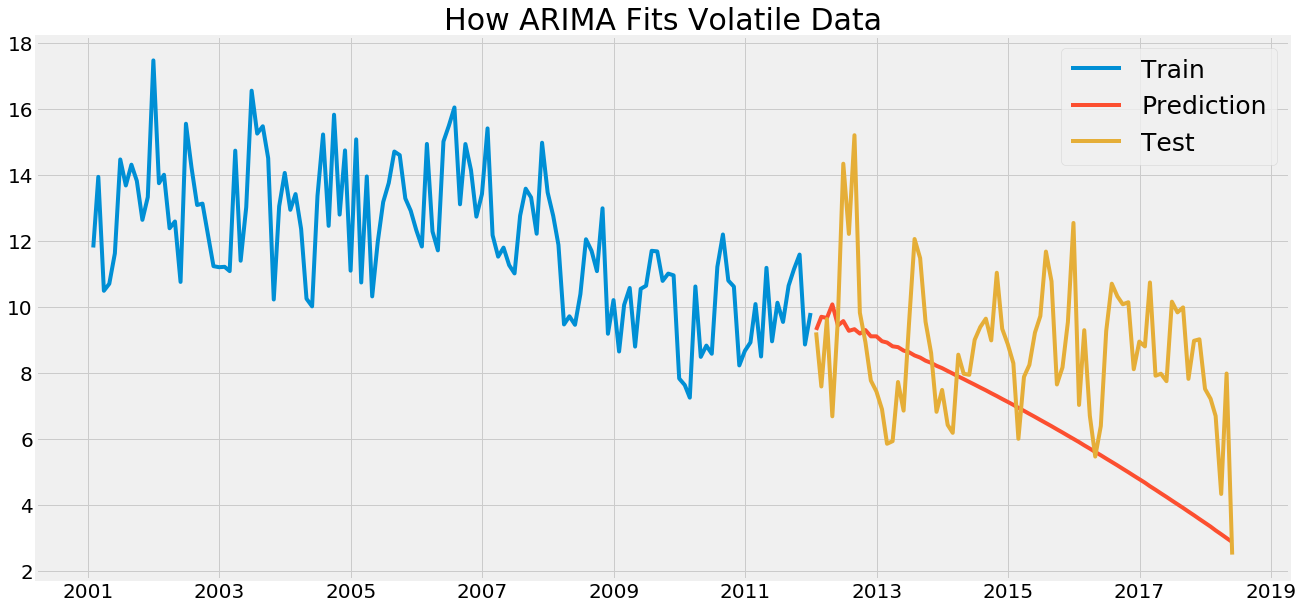

In [12]:
best_parameters = (5, 2, 1)
split_date = '2012-01-01'
data = pm10_df['bc_pm10']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = ARIMA(train, order=best_parameters)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

pred_df = pd.DataFrame(prediction[0], index= test.index)
mae = mean_absolute_error(test, pred_df)
mse = mean_squared_error(test, pred_df)
rmse = math.sqrt(mse)

plt.figure(figsize=(20, 10))
plt.plot(train, label='Train')
plt.plot(pred_df, label='Prediction')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize= 25)
plt.show()

# Conclusion
---
Sau khi chạy mô hình ARIMA 5,1,2. {'rmse': 3.2601517408412013, 'aic': 516.177215389575}
rmse có vẻ thấp nhưng nhìn vào biểu đồ, dường như có vấn đề gì đó. CÓ lẽ dữ liệu này có tính theo mùa.
Sẽ tự train thêm SARIMAX vì cái này xử lý được yếu tố mùa vụ.